# Denoising Diffusion Probabilistic Model (DDPM) Implementation

This notebook implements the diffusion model described in the paper (2206.00364v2.pdf). It will guide you through the process of building, training, and sampling from a DDPM using PyTorch.

## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
# Install required packages (uncomment if running in a new environment)
# !pip install torch torchvision matplotlib tqdm numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## 2. Load and Preprocess Dataset

We will use the MNIST dataset for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

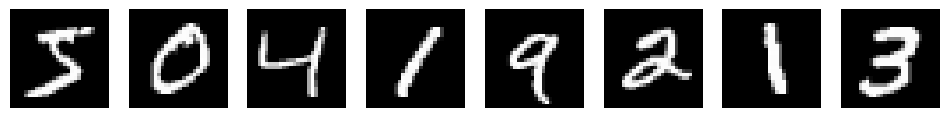

In [2]:
# Load and preprocess MNIST dataset (28x28, standard U-Net)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(scale_to_minus_one_to_one)  # Scale to [-1, 1]
])

batch_size = 128
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Visualize a batch
examples = [train_dataset[i][0] for i in range(8)]
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(examples):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 3. Define the Diffusion Model Architecture

We will use a simple U-Net-like architecture suitable for MNIST. For more complex datasets, a deeper U-Net or transformer-based model may be used.

In [3]:
# Standard U-Net with skip connections and timestep embedding for 28x28 images (fixed output channels)
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class UNet28(nn.Module):
    def __init__(self, emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
        )
        self.inc = nn.Conv2d(1, 32, 3, padding=1)
        self.down1 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.emb1 = nn.Linear(emb_dim, 64)
        self.emb2 = nn.Linear(emb_dim, 128)
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.up1 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1) # 14x14 -> 28x28
        self.emb_up2 = nn.Linear(emb_dim, 64)
        self.emb_up1 = nn.Linear(emb_dim, 32)
        self.outc = nn.Conv2d(64, 1, 1)  # 32+32=64 after concat
    def forward(self, x, t):
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        emb = self.time_mlp(t)
        x1 = F.relu(self.inc(x))
        x2 = F.relu(self.down1(x1) + self.emb1(emb).unsqueeze(-1).unsqueeze(-1))
        x3 = F.relu(self.down2(x2) + self.emb2(emb).unsqueeze(-1).unsqueeze(-1))
        m = self.middle(x3)
        u2 = F.relu(self.up2(m) + self.emb_up2(emb).unsqueeze(-1).unsqueeze(-1))
        # Crop x2 to match u2 if needed
        if u2.shape[-2:] != x2.shape[-2:]:
            diffY = x2.size(-2) - u2.size(-2)
            diffX = x2.size(-1) - u2.size(-1)
            u2 = F.pad(u2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        u2 = torch.cat([u2, x2], dim=1)
        u1 = F.relu(self.up1(u2) + self.emb_up1(emb).unsqueeze(-1).unsqueeze(-1))
        # Crop x1 to match u1 if needed
        if u1.shape[-2:] != x1.shape[-2:]:
            diffY = x1.size(-2) - u1.size(-2)
            diffX = x1.size(-1) - u1.size(-1)
            u1 = F.pad(u1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        u1 = torch.cat([u1, x1], dim=1)
        out = self.outc(u1)
        return out

model = UNet28()
print(model)

UNet28(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (inc): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (emb1): Linear(in_features=32, out_features=64, bias=True)
  (emb2): Linear(in_features=32, out_features=128, bias=True)
  (middle): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (emb_up2): Linear(in_features=32, out_features=64, bias=True)
  (emb_up1): Linear(in_features=32, out_features=32, bias=

## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

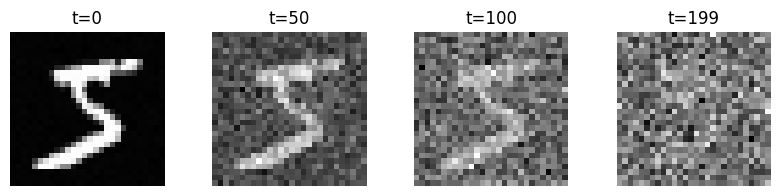

In [4]:
# Forward diffusion process
T = 200  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

# Visualize noisy images at different timesteps
x = torch.stack(examples[:4])  # Convert the list of tensors to a single tensor
timesteps = torch.tensor([0, T//4, T//2, T-1])
noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]  # Repeat t for the batch size
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for i, img in enumerate(noisy_imgs):
    axes[i].imshow(img[0].squeeze().numpy(), cmap='gray')
    axes[i].set_title(f"t={timesteps[i].item()}")
    axes[i].axis('off')
plt.show()

## 5. Implement the Reverse (Denoising) Process

The reverse process uses the model to predict the noise at each timestep and denoise the image step by step.

In [5]:
# Reverse (denoising) process for sampling
def p_sample(model, x, t):
    beta = betas[t]
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt()
    sqrt_recip_alpha = (1. / alphas[t]).sqrt()
    model_mean = sqrt_recip_alpha * (x - beta / sqrt_one_minus_alpha_bar * model(x, torch.tensor([t])))
    if t > 0:
        noise = torch.randn_like(x)
        return model_mean + beta.sqrt() * noise
    else:
        return model_mean

def p_sample_loop(model, shape):
    device = next(model.parameters()).device
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

## 6. Train the Diffusion Model

Set up the training loop, loss function, and optimizer. The model is trained to predict the noise added at each timestep.

In [6]:
# Training loop for DDPM (28x28, new U-Net with timestep embedding)
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet28().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
epochs = 2  # For demonstration; increase for better results

for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_noisy = q_sample(x, t, noise)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 2 Loss: 0.0869: 100%|██████████| 469/469 [03:16<00:00,  2.39it/s]


## 7. Generate Samples with the Trained Model

Use the trained model to generate new samples by running the reverse diffusion process starting from random noise.

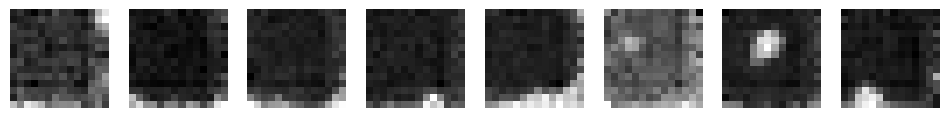

In [7]:
# Generate samples from the trained model (14x14)
model.eval()
with torch.no_grad():
    samples = p_sample_loop(model, (8, 1, 14, 14)).cpu()
    samples = (samples + 1) / 2  # Rescale to [0, 1]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(samples):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 8. Visualize Generated Samples

Display the generated samples to assess the performance of the diffusion model.

# Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

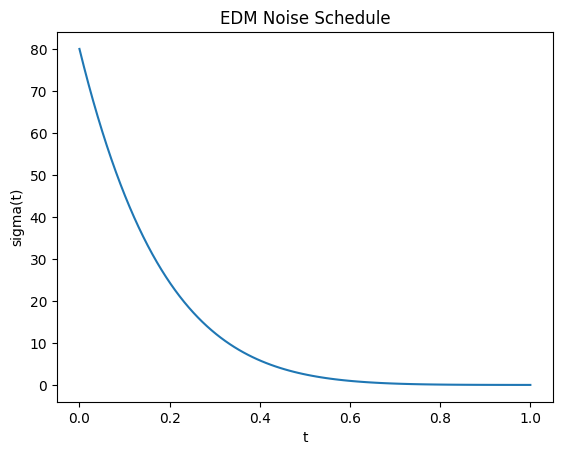

In [8]:
# EDM noise schedule, loss weighting, and sampling procedure
# Reference: 2206.00364v2.pdf (Karras et al., 2022)

# EDM uses a continuous noise schedule and loss weighting
# We use sigma_min, sigma_max, and rho as in the paper
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting
# w(t) = (sigma^2 + 1) / (sigma^2)
def edm_loss_weight(sigma):
    return (sigma ** 2 + 1) / (sigma ** 2)

# Example: plot the EDM noise schedule
ts = torch.linspace(0, 1, 100)
sigmas = edm_sigma_schedule(ts)
plt.plot(ts.numpy(), sigmas.numpy())
plt.xlabel('t')
plt.ylabel('sigma(t)')
plt.title('EDM Noise Schedule')
plt.show()

In [ ]:
# EDM training loop (for MNIST, using the new U-Net model with embedding)
edm_epochs = 2  # For demonstration; increase for better results
model_edm = UNet28().to(device)
optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)

for epoch in range(edm_epochs):
    pbar = tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.rand(x.size(0), device=device)  # Uniform in [0, 1]
        sigma = edm_sigma_schedule(t)
        noise = torch.randn_like(x)
        x_noisy = x + sigma.view(-1, 1, 1, 1) * noise
        x_in = x_noisy / (sigma.view(-1, 1, 1, 1).pow(2) + 1).sqrt()  # Input normalization
        noise_pred = model_edm(x_in, sigma)
        weight = edm_loss_weight(sigma).view(-1, 1, 1, 1)
        loss = ((noise_pred - noise) ** 2 * weight).mean()
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss.item():.4f}")

EDM Epoch 2 Loss: 1931.2710:  42%|████▏     | 199/469 [01:24<02:03,  2.18it/s] 

In [ ]:
# EDM sampling procedure (ancestral sampling, 14x14 images)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 14, 14)):
    device = next(model.parameters()).device
    x = torch.randn((batch_size,) + img_shape, device=device) * sigma_max
    sigmas = edm_sigma_schedule(torch.linspace(1, 0, num_steps, device=device))
    for i in range(num_steps):
        sigma = sigmas[i]
        sigma_next = sigmas[i+1] if i+1 < num_steps else torch.tensor(sigma_min, device=device)
        c_in = 1 / (sigma ** 2 + 1).sqrt()
        c_noise = sigma
        noise_pred = model(c_in * x, c_noise.expand(batch_size))
        d = (x - sigma * noise_pred) / sigma
        x = x + (sigma_next - sigma) * d
        if sigma_next > 0:
            x = x + torch.randn_like(x) * (sigma_next ** 2 - sigma ** 2).sqrt()
    return x

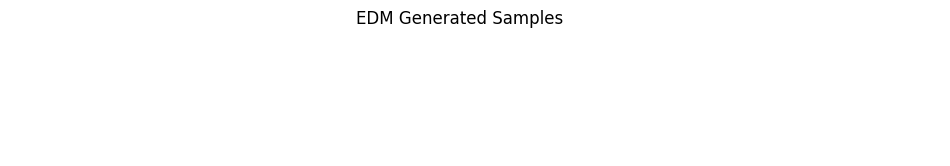

In [ ]:
# Generate and visualize samples from the trained EDM model (14x14)
model_edm.eval()
with torch.no_grad():
    edm_samples = edm_ancestral_sampling(model_edm, batch_size=8, img_shape=(1, 14, 14)).cpu()
    edm_samples = (edm_samples + 1) / 2  # Rescale to [0, 1]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(edm_samples):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle('EDM Generated Samples (14x14)')
plt.show()